In [1]:
require('ggplot2')
require('nls.multstart')
require('broom')
require('tidyverse')
require('rTPC')
require('dplyr')

rm(list=ls())
graphics.off()
setwd("/home/primuser/Documents/VByte/VecMismatchPaper1/code/")

Loading required package: ggplot2

Loading required package: nls.multstart

Loading required package: broom

Loading required package: tidyverse

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘tidyverse’”
Loading required package: rTPC

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#take a look at the different models available
get_model_names()

[1] "beta_2012"             "boatman_2017"          "briere2_1999"         
 [4] "delong_2017"           "flinn_1991"            "gaussian_1987"        
 [7] "hinshelwood_1947"      "joehnk_2008"           "johnsonlewin_1946"    
[10] "kamykowski_1985"       "lactin2_1995"          "modifiedgaussian_2006"
[13] "oneill_1972"           "pawar_2018"            "quadratic_2008"       
[16] "ratkowsky_1983"        "rezende_2019"          "sharpeschoolfull_1981"
[19] "sharpeschoolhigh_1981" "sharpeschoollow_1981"  "spain_1982"           
[22] "thomas_2012"           "thomas_2017"           "weibull_1995"

In [3]:
#read in the trait data
final_trait_data <- read.csv('../data/Final_Traitofinterest.csv')

In [4]:
#filter out sets that less than the required parameters for schoolfield-high ()
final_trait_data <- dplyr::filter(final_trait_data,
                                  originaltraitname != 'Adult survival' &
                                    originalid != 'MSS0059' &
                                    originaltraitname != 'Adult longevity (female, bloodfed)' &
                                    originaltraitname != 'Adult longevity (male)' &
                                    originaltraitname != 'Adult survival (female, bloodfed)' &
                                    originaltraitname != 'Adult survival (male)' )

In [5]:
#remove completely irrelevant columns 
df <- final_trait_data[,colSums(is.na(final_trait_data))<nrow(final_trait_data)]

In [6]:
#filter to single species and trait
df2 <- dplyr::filter(df, interactor1 == 'Aedes albopictus'& originaltraitname == 'Development Rate')

In [7]:
df1 <- df %>%
  select('originalid', 'originaltraitname', 'originaltraitunit', 'originaltraitvalue', 'interactor1', 'ambienttemp')

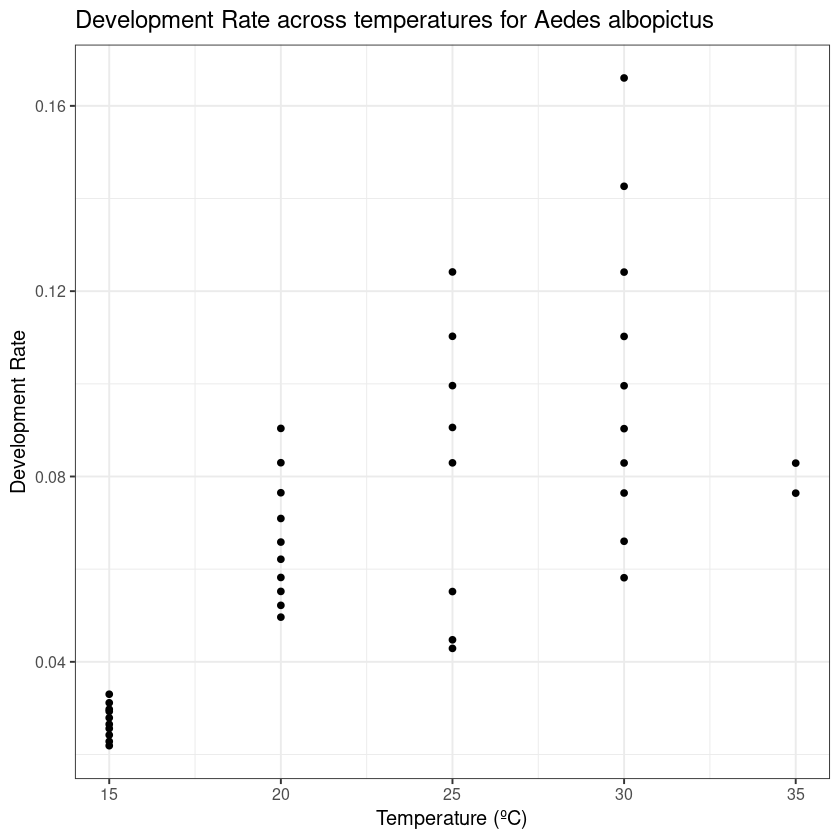

In [8]:
#visualize
ggplot(df2, aes(ambienttemp, originaltraitvalue))+
  geom_point()+
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Development Rate',
       title = 'Development Rate across temperatures for Aedes albopictus')

In [9]:
# choose model
mod = 'sharpschoolhigh_1981'

In [10]:
# get start vals
start_vals <- get_start_vals(df2$ambienttemp, df2$originaltraitvalue, model_name = 'sharpeschoolhigh_1981')

In [11]:
# get limits
low_lims <- get_lower_lims(df2$ambienttemp, df2$originaltraitvalue, model_name = 'sharpeschoolhigh_1981')
upper_lims <- get_upper_lims(df2$ambienttemp, df2$originaltraitvalue, model_name = 'sharpeschoolhigh_1981')

In [12]:
start_vals

r_tref           e          eh          th 
 0.06905828  0.60095423  0.31244305 30.83333333

In [13]:
low_lims

r_tref      e     eh     th 
     0      0      0      1

In [14]:
upper_lims

r_tref        e       eh       th 
 0.16602 10.00000 20.00000 35.00000

In [15]:
# fit model
fit <- nls_multstart(originaltraitvalue~sharpeschoolhigh_1981(temp = ambienttemp, r_tref,e,eh,th, tref = 15),
                     data = df2,
                     iter = 500,
                     start_lower = start_vals - 10,
                     start_upper = start_vals + 10,
                     lower = low_lims,
                     upper = upper_lims,
                     supp_errors = 'Y')
fit

Nonlinear regression model
  model: originaltraitvalue ~ sharpeschoolhigh_1981(temp = ambienttemp,     r_tref, e, eh, th, tref = 15)
   data: data
  r_tref        e       eh       th 
 0.03531  1.44272  1.74738 22.48851 
 residual sum-of-squares: 0.02037

Number of iterations to convergence: 72 
Achieved convergence tolerance: 1.49e-08

In [16]:
# calculate additional traits
calc_params(fit) %>%
  # round for easy viewing
  mutate_all(round, 2)

rmax,topt,ctmin,ctmax,e,eh,q10,thermal_safety_margin,thermal_tolerance,breadth,skewness
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1,29.35,5.54,Inf,0.65,0.39,2.4,Inf,Inf,12.42,0.26


In [17]:
# predict new data
new_data <- data.frame(ambienttemp = seq(min(df2$ambienttemp), max(df2$ambienttemp), 0.5))
preds <- augment(fit, newdata = new_data)

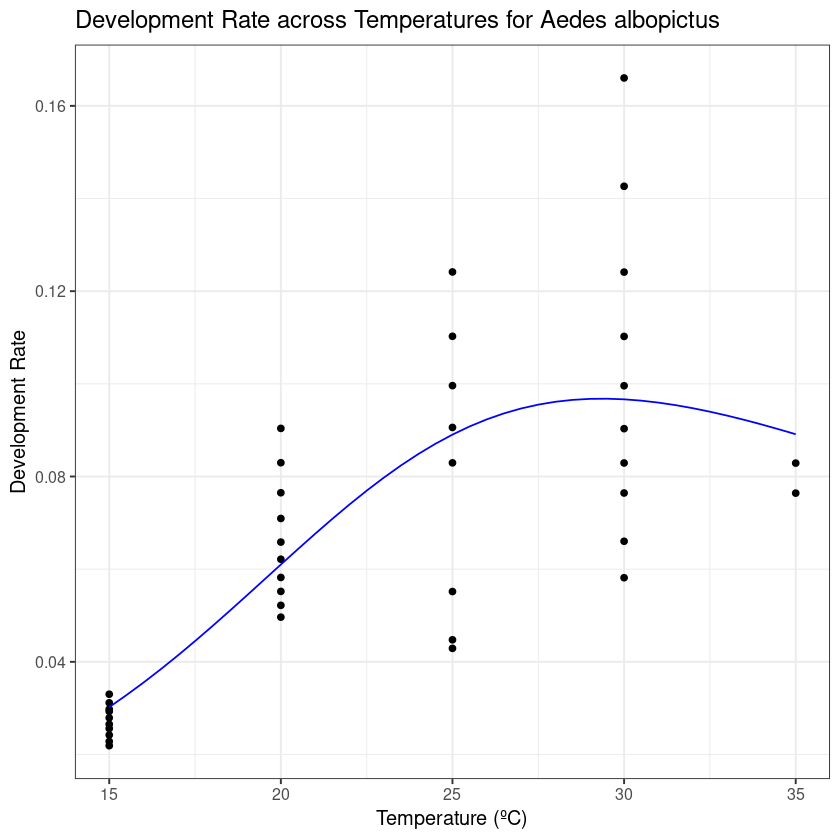

In [18]:
#visualize with new line
ggplot(df2, aes(ambienttemp, originaltraitvalue))+
  geom_point()+
  geom_line(aes(ambienttemp, .fitted), preds, col = 'blue') +
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Development Rate',
       title = 'Development Rate across Temperatures for Aedes albopictus')

In [19]:
unique(df$originalid)

[1] csm1B   csm1E   csm1A   csm1C   csm1D   csm5A   csm5I   csm5B   csm5C  
 [10] csm5D   csm5E   csm5F   csm5G   csm5H   MSS0001 MSS0003 MSS0005 MSS0002
 [19] MSS0067 MSS0068 MSS0065 MSS0066 csm8I   csm8J   csm8K   csm8L   csm8W  
 [28] csm8X   csm8Y   csm8Z   csm8AA  csm8AB  csm8AC  csm8AD  csm8M   csm8N  
 [37] csm8O   csm8P   csm8Q   csm8AE  csm8A   csm8B   csm8C   csm8D   csm8E  
 [46] csm8F   csm8G   csm8H   csm8R   csm8S   csm8T   csm8U   csm8V   csm2A  
 [55] MTD2084 csm2R   csm2B   csm2C   csm2D   csm2E   csm3F   csm3G   csm3H  
 [64] csm3I   MTD2088 MTD2086 MTD2085 csm2S   csm2J   csm2K   csm2L   csm2M  
 [73] csm2N   csm2O   csm2P   csm2Q   MTD2164 MTD2165 MTD2166 MTD2142 csm4A  
 [82] csm4B   csm4C   csm4D   csm4E   csm4E_2 csm4E_3 csm4E_4 csm4E_5 csm4E_6
 [91] csm4F   csm4G   csm4H   csm4P   csm4Q   csm4R   csm4S   csm4T   csm4U  
[100] csm4V   csm4W   csm4X   csm4Y   csm4Z   csm4I   csm4J   csm4K   csm4L  
[109] csm4M   csm4N   csm4O   MSS0034 MSS0049 MSS0053 MSS0054 MSS0048 MSS0043
[118] MSS0033 MSS0050 MSS0051 MSS0052 MTD2161 MTD2162 MTD2163 MTD2159 MTD2160
[127] MTD2158 MTD2156 MTD2157 csm6B   csm6C   csm6D   csm6E   csm6F   csm6G  
[136] csm6H   csm6I   MTD2119 MTD2147 MTD2063 MTD2064 MTD2065 MTD2066 MTD2067
[145] MTD2068 MTD2072 MTD2069 MTD2070 MTD2095 MTD2096 MTD2097 MTD2098 MTD2167
[154] csm7B   csm7C   csm7D   csm7E   csm7F   csm7G   csm7A   MTD2148 MTD2149
[163] MTD2151 MTD2152 MTD2175 MTD2176 MTD2177 MTD2178 MTD2179 MTD2180 MTD2187
[172] MTD2188 MTD2189 MTD2190 MTD2191 MTD2192 MTD2181 MTD2182 MTD2183 MTD2184
[181] MTD2185 MTD2186 MTD2150 MTD2153 MTD2089 MTD2091 MTD2093 MTD2090 csm7I  
[190] csm7J   csm7K   csm7L   csm7H   MTD2132 MTD2133 MTD2134 MTD2135 MTD2123
[199] MTD2129 MTD2120 MTD2122 MTD2125 MTD2126 MTD2128 MTD2131 MTD2121 MTD2124
[208] MTD2127 MTD2130
215 Levels: csm1A csm1B csm1C csm1D csm1E csm2A csm2B csm2C csm2D ... MTD2192

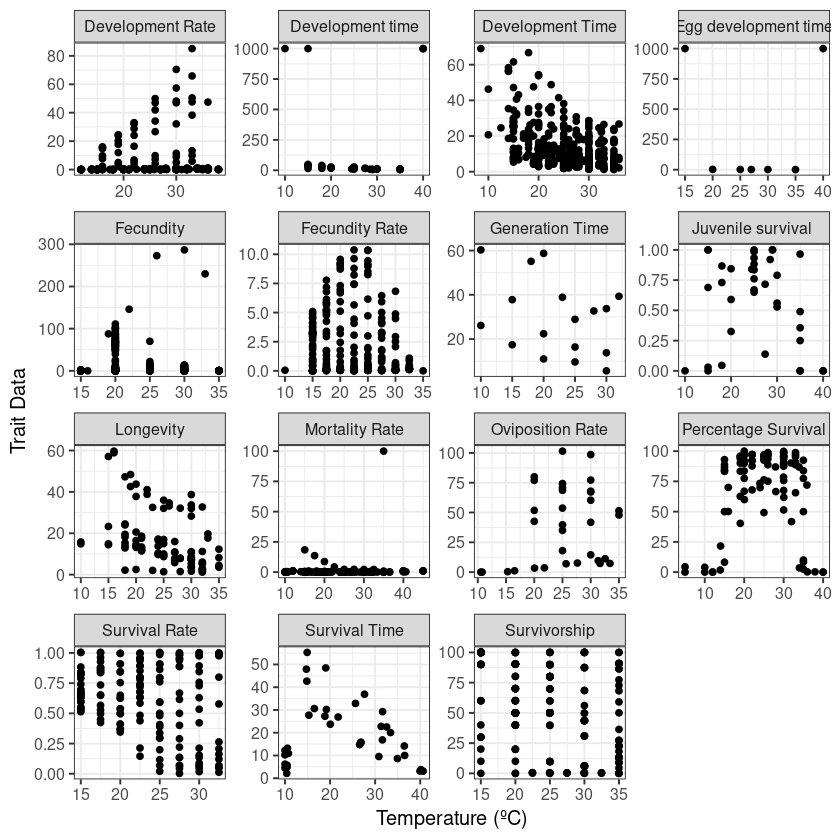

In [20]:
#visualize all together
ggplot(df, aes(ambienttemp, originaltraitvalue))+
  geom_point()+
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Trait Data')+
  facet_wrap(df$originaltraitname, scales = 'free' )

In [21]:
#mutate some things
df10<-  mutate(df1, modifiedtraitvalue = ifelse(originaltraitname == 'Mortality Rate' , 1/originaltraitvalue,
                ifelse(originaltraitname == 'Egg development time' , 1/originaltraitvalue,
                  ifelse(originaltraitname == 'Generation time' , 1/originaltraitvalue,
                    ifelse(originaltraitname == 'Survival Rate' , 1/originaltraitvalue,
                      ifelse(originaltraitname == 'Development time' , 1/originaltraitvalue,
                        ifelse(originaltraitname == 'Development Time' , 1/originaltraitvalue,
                          ifelse(originaltraitname == 'Survivorship' , 1/originaltraitvalue,
                            ifelse(originaltraitname == 'Longevity' , 1/originaltraitvalue,
                                       originaltraitvalue)))))))))

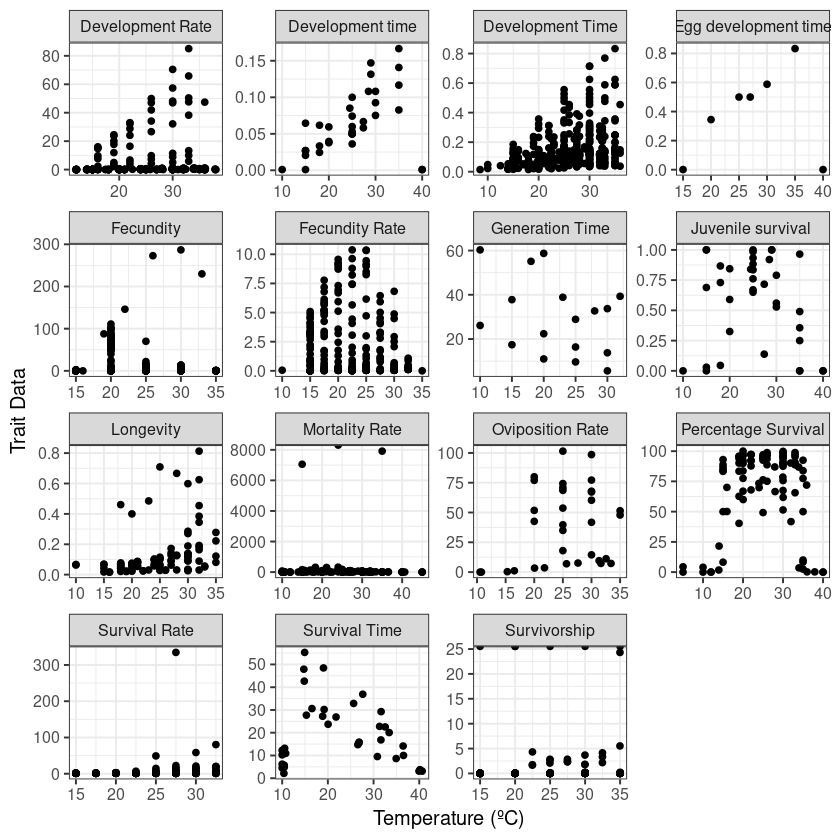

In [22]:
#visualize all together with modified data
ggplot(df10, aes(ambienttemp, modifiedtraitvalue))+
  geom_point()+
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Trait Data')+
  facet_wrap(df10$originaltraitname, scales = 'free' )

In [23]:
#test a loop mean of temperature
shoobop <- list()
for (x in unique(df$originalid)){
  # Subset
  dfsub <- subset(df, df$originalid == x)
  # Apply function
  mean(dfsub$ambienttemp)
  shoobop[[x]] <- print(paste0(x, ": ", mean(dfsub$ambienttemp)))
}

[1] "csm1B: 22.6779166666667"
[1] "csm1E: 23.0983333333333"
[1] "csm1A: 23.0983333333333"
[1] "csm1C: 22.6779166666667"
[1] "csm1D: 23.0983333333333"
[1] "csm5A: 23"
[1] "csm5I: 26.6666666666667"
[1] "csm5B: 22.5"
[1] "csm5C: 22.5"
[1] "csm5D: 25"
[1] "csm5E: 25"
[1] "csm5F: 25"
[1] "csm5G: 25"
[1] "csm5H: 25"
[1] "MSS0001: 25"
[1] "MSS0003: 25"
[1] "MSS0005: 20"
[1] "MSS0002: 25"
[1] "MSS0067: 21.75"
[1] "MSS0068: 21.75"
[1] "MSS0065: 24.4"
[1] "MSS0066: 24.4"
[1] "csm8I: 25"
[1] "csm8J: 25"
[1] "csm8K: 25"
[1] "csm8L: 25"
[1] "csm8W: 25"
[1] "csm8X: 25"
[1] "csm8Y: 25"
[1] "csm8Z: 25"
[1] "csm8AA: 25"
[1] "csm8AB: 25"
[1] "csm8AC: 25"
[1] "csm8AD: 25"
[1] "csm8M: 15"
[1] "csm8N: 20"
[1] "csm8O: 25"
[1] "csm8P: 30"
[1] "csm8Q: 35"
[1] "csm8AE: 25"
[1] "csm8A: 27.75"
[1] "csm8B: 25"
[1] "csm8C: 25"
[1] "csm8D: 25"
[1] "csm8E: 25"
[1] "csm8F: 27.625"
[1] "csm8G: 25"
[1] "csm8H: 27.75"
[1] "csm8R: 15"
[1] "csm8S: 20"
[1] "csm8T: 25"
[1] "csm8U: 30"
[1] "csm8V: 35"
[1] "csm2A: 23.72577855

In [24]:
#base loop for what needs to be flipped
modelfit <- list()
parameters <- list()
for (x in unique(df$originalid)){
  # Subset
  dfsub <- subset(df, df$originalid == x)
  # get start vals
  start_vals <- get_start_vals(dfsub$ambienttemp, dfsub$originaltraitvalue, model_name = 'sharpeschoolhigh_1981')

  # get limits
  low_lims <- get_lower_lims(dfsub$ambienttemp, dfsub$originaltraitvalue, model_name = 'sharpeschoolhigh_1981')
  upper_lims <- get_upper_lims(dfsub$ambienttemp, dfsub$originaltraitvalue, model_name = 'sharpeschoolhigh_1981')
  
  modelfit[[x]] <-  nls_multstart(originaltraitvalue~sharpeschoolhigh_1981(temp = ambienttemp, r_tref,e,eh,th, tref = 15),
                             data = dfsub,
                             iter = 500,
                             start_lower = start_vals - 10,
                             start_upper = start_vals + 10,
                             lower = low_lims,
                             upper = upper_lims,
                             supp_errors = 'Y')
  parameters[[x]] <- calc_params(modelfit[[x]])
  
}

In [25]:
#loop with flips incorporated
modelfit2 <- list()
parameters2 <- list()
for (x in unique(df10$originalid)){
  # Subset
  dfsub <- subset(df10, df10$originalid == x)
  # get start vals
  start_vals <- get_start_vals(dfsub$ambienttemp, dfsub$modifiedtraitvalue, model_name = 'sharpeschoolhigh_1981')
  
  # get limits
  low_lims <- get_lower_lims(dfsub$ambienttemp, dfsub$modifiedtraitvalue, model_name = 'sharpeschoolhigh_1981')
  upper_lims <- get_upper_lims(dfsub$ambienttemp, dfsub$modifiedtraitvalue, model_name = 'sharpeschoolhigh_1981')
  
  modelfit2[[x]] <-  nls_multstart(modifiedtraitvalue~sharpeschoolhigh_1981(temp = ambienttemp, r_tref,e,eh,th, tref = 15),
                                  data = dfsub,
                                  iter = 500,
                                  start_lower = start_vals - 10,
                                  start_upper = start_vals + 10,
                                  lower = low_lims,
                                  upper = upper_lims,
                                  supp_errors = 'Y')
  parameters2[[x]] <- calc_params(modelfit2[[x]])
  
}

In [26]:
#build and clean final dataframe (104 work well)
paramdf <- df10 %>%
  select('originalid', 'interactor1', 'originaltraitname')
paramdf <- paramdf %>% distinct((originalid), .keep_all = TRUE)
boundparams <- bind_rows(parameters2, .id = "originalid")
boundparams <- merge(paramdf, boundparams)
drops <- c("(originalid)")
boundparams <- boundparams[ , !(names(boundparams) %in% drops)]

Warning message:
“Removed 105 rows containing missing values (geom_point).”


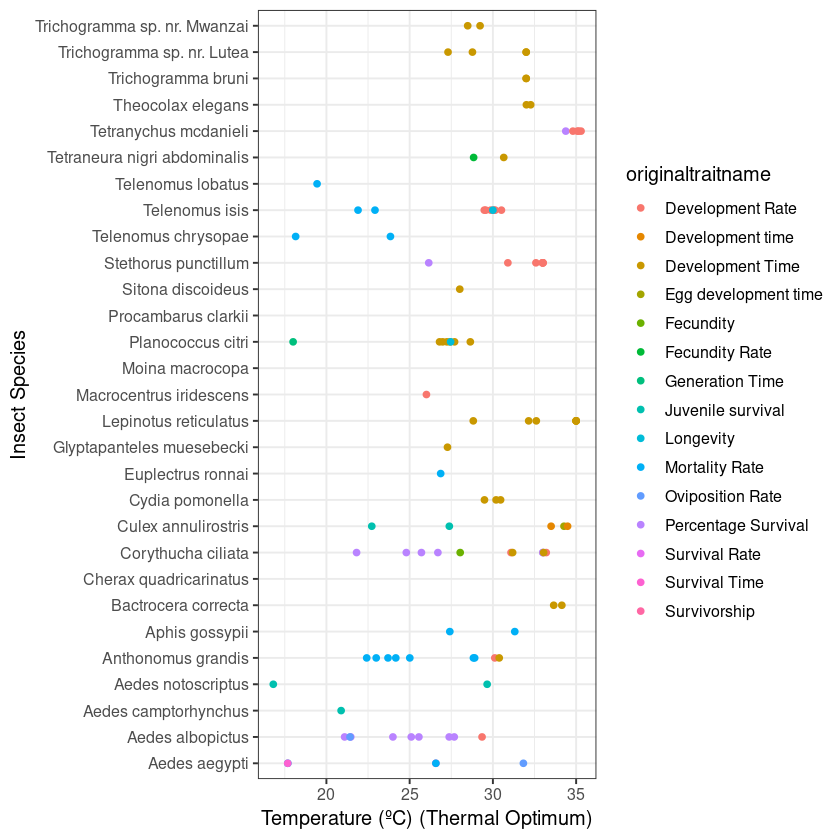

In [27]:
#plot
ggplot(boundparams, aes(topt, interactor1, color = originaltraitname))+
         geom_point()+
         theme_bw(base_size = 12) +
         labs(x = 'Temperature (ºC) (Thermal Optimum)',
              y = 'Insect Species')